# Model-Based Reinforcement Learning

## Principle
We consider the optimal control problem of an MDP with a **known** reward function $R$ and subject to **unknown deterministic** dynamics $s_{t+1} = f(s_t, a_t)$:

$$\max_{(a_0,a_1,\dotsc)} \sum_{t=0}^\infty \gamma^t R(s_t,a_t)$$

In **model-based reinforcement learning**, this problem is solved in **two steps**:
1. **Model learning**:
We learn a model of the dynamics $f_\theta \simeq f$ through regression on interaction data.
2. **Planning**:
We leverage the dynamics model $f_\theta$ to compute the optimal trajectory $$\max_{(a_0,a_1,\dotsc)} \sum_{t=0}^\infty \gamma^t R(\hat{s}_t,a_t)$$ following the learnt dynamics $\hat{s}_{t+1} = f_\theta(\hat{s}_t, a_t)$.

(We can easily extend to unknown rewards and stochastic dynamics, but we consider the simpler case in this notebook for ease of presentation)


## Motivation

### Sparse rewards
* In model-free reinforcement learning, we only obtain a reinforcement signal when encountering rewards. In environment with **sparse rewards**, the chance of obtaining a reward randomly is **negligible**, which prevents any learning.
* However, even in the **absence of rewards** we still receive a **stream of state transition data**. We can exploit this data to learn about the task at hand.

### Complexity of the policy/value vs dynamics:
Is it easier to decide which action is best, or to predict what is going to happen?
* Some problems can have **complex dynamics** but a **simple optimal policy or value function**. For instance, consider the problem of learning to swim. Predicting the movement requires understanding fluid dynamics and vortices while the optimal policy simply consists in moving the limbs in sync.
* Conversely, other problems can have **simple dynamics** but **complex policies/value functions**. Think of the game of Go, its rules are simplistic (placing a stone merely changes the board state at this location) but the corresponding optimal policy is very complicated.

Intuitively, model-free RL should be applied to the first category of problems and model-based RL to the second category.

### Inductive bias
Oftentimes, real-world problems exhibit a particular **structure**: for instance, any problem involving motion of physical objects will be **continuous**. It can also be **smooth**, **invariant** to translations, etc. This knowledge can then be incorporated in machine learning models to foster efficient learning. In contrast, there can often be **discontinuities** in the policy decisions or value function: e.g. think of a collision vs near-collision state.

###  Sample efficiency
Overall, it is generally recognized that model-based approaches tend to **learn faster** than model-free techniques (see e.g. [[Sutton, 1990]](http://papersdb.cs.ualberta.ca/~papersdb/uploaded_files/paper_p160-sutton.pdf.stjohn)).

### Interpretability
In real-world applications, we may want to know **how a policy will behave before actually executing it**, for instance for **safety-check** purposes. However, model-free reinforcement learning only recommends which action to take at current time without being able to predict its consequences. In order to obtain the trajectory, we have no choice but executing the policy. In stark contrast, model-based methods a more interpretable in the sense that we can probe the policy for its intended (and predicted) trajectory.

## Our challenge: Automated Parking System

We consider the **parking-v0** task of the [highway-env](https://github.com/eleurent/highway-env) environment. It is a **goal-conditioned continuous control** task where an agent **drives a car** by controlling the gaz pedal and steering angle and must **park in a given location** with the appropriate heading.

This MDP has several properties which justifies using model-based methods:
* The policy/value is highly dependent on the goal which adds a significant level of complexity to a model-free learning process, whereas the dynamics are completely independent of the goal and hence can be simpler to learn.
* In the context of an industrial application, we can reasonably expect for safety concerns that the planned trajectory is required to be known in advance, before execution.

###  Warming up
We start with a few useful installs and imports:

In [ ]:
# Install environment and visualization dependencies 
# !pip install highway-env

# Add project root to Python path to ensure imports work
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Environment
import gymnasium as gym
from gymnasium.envs.registration import register
import importlib
import highway_env
# Reload to pick up any new environment registrations
importlib.reload(highway_env)

# Explicitly register the reverse parking environment to ensure it's available
from highway_env.envs.reverse_parking_dynObs_env import ReverseParkingDynObsEnv
register(
    id="parking-reverse-dynObs-v0",
    entry_point="highway_env.envs.reverse_parking_dynObs_env:ReverseParkingDynObsEnv",
)

gym.register_envs(highway_env)

# Models and computation
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple

# Visualization
import matplotlib.pyplot as plt
import copy
%matplotlib inline

# deleting old videos
import shutil
import os

folder_path = r"/Users/mehaksingal/Documents/CS269-Parking-2/videos"

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print("Video Folder deleted.")
else:
    print("Video Folder does not exist.")

We also define a simple helper function for visualization of episodes:

In [2]:
import sys
from tqdm.notebook import trange
from tqdm import trange
# !pip install tensorboardx gym pyvirtualdisplay
# !apt-get install -y xvfb ffmpeg
# !git clone https://github.com/Farama-Foundation/HighwayEnv.git 2> /dev/null
sys.path.insert(0, '/home/aayush_wsl/cs269_rl_parking/CS269-Parking/scripts')
from utils import record_videos, show_videos

### Let's try it!

Make the environment, and run an episode with random actions:

In [3]:
# Full configuration dictionary for parking-v0 environment
parking_config = {
    # Observation configuration
    "observation": {
        "type": "KinematicsGoal",
        "features": ["x", "y", "vx", "vy", "cos_h", "sin_h"],
        "scales": [100, 100, 5, 5, 1, 1],
        "normalize": False,
    },
    
    # Action configuration
    "action": {
        "type": "ContinuousAction",
        "acceleration_range": (-1, 1),
        # "steering_range": np.deg2rad(60),
        # "speed_range": (-3.0, 3.0),
    },
    
    # Reward parameters
    "reward_weights": [1, 1, 0.1, 0.1, 0.5, 0.5],  # Weights for [x, y, vx, vy, cos_h, sin_h]
    "success_goal_reward": 0.10,
    "collision_reward": -5,
    
    # Vehicle control parameters
    "steering_range": np.deg2rad(45),  # Maximum steering angle in radians
    
    # Simulation parameters
    "simulation_frequency": 15,  # Hz
    "policy_frequency": 5,       # Hz
    "duration": 200,             # Maximum episode duration in steps
    
    # Rendering parameters
    "screen_width": 600,
    "screen_height": 300,
    "centering_position": [0.5, 0.5],
    "scaling": 7,
    "show_trajectories": True,
    
    # Environment setup
    "controlled_vehicles": 1,    # Number of vehicles to control
    "vehicles_count": 0,         # Number of parked vehicles (obstacles)
    "add_walls": True,           # Whether to add boundary walls
    
    # Manual vehicle positioning (NEW FEATURE)
    # "manual_vehicle_positions": [
    #     {"lane_index": ('a', 'b', 0), "longitudinal": 2.0, "speed": 0.0},
    #     {"lane_index": ('a', 'b', 2), "longitudinal": 2.0, "speed": 0.0},
    #     {"lane_index": ('a', 'b', 4), "longitudinal": 2.0, "speed": 0.0},
    #     {"lane_index": ('a', 'b', 6), "longitudinal": 2.0, "speed": 0.0},
    #     {"lane_index": ('b', 'c', 1), "longitudinal": 4.0, "speed": 0.0},
    #     {"lane_index": ('b', 'c', 3), "longitudinal": 4.0, "speed": 0.0},
    #     {"lane_index": ('b', 'c', 5), "longitudinal": 4.0, "speed": 0.0},
    #     {"lane_index": ('b', 'c', 7), "longitudinal": 4.0, "speed": 0.0},
    # ],

    # Additional parameters from AbstractEnv
    "offscreen_rendering": False,
    "manual_control": False,
    "real_time_rendering": False,
}

In [4]:
config={
        # "vehicles_count": 0,  # Number of parked vehicles #random.randint(0, 25)
        # "freeze_ego_vehicle": False,  # Set to True to freeze ego vehicle (for testing dynamic obstacle)
        # Dynamic obstacle settings (optional - these are defaults)
        "moving_obstacle": False,
        # "moving_obstacle_speed": 1.0,  # m/s - how fast the obstacle moves
        # "moving_obstacle_position": [26.0, -14.0],  # Top rightmost parking spot [x, y]
        # "moving_obstacle_heading": np.pi / 2,  # Heading in radians (π/2 = pointing up, vertical),
        # Reward weights: [x, y, vx, vy, cos_h, sin_h]
        # Increased y-weight from 0.3 to 1.0 for better reverse parking performance
        # "reward_weights": [1.0, 1.0, 0.1, 0.1, 0.05, 0.05],  # Emphasize position, especially y
    }



In [5]:
# env = gym.make("parking-reverse-dynObs-v0", render_mode="rgb_array", config=config)
env = gym.make("parking-reverse-dynObs-v0", render_mode="rgb_array")
env = record_videos(env)
env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
env.close()
show_videos()

The environment is a `GoalEnv`, which means the agent receives a dictionary containing both the current `observation` and the `desired_goal` that conditions its policy.

In [6]:
print("Observation format:", obs)

Observation format: OrderedDict([('observation', array([0.00802012, 0.17850416, 0.0840617 , 0.13424183, 0.53072767,
       0.84754241])), ('achieved_goal', array([0.00802012, 0.17850416, 0.0840617 , 0.13424183, 0.53072767,
       0.84754241])), ('desired_goal', array([-1.000000e-01, -1.400000e-01,  0.000000e+00,  0.000000e+00,
        6.123234e-17, -1.000000e+00]))])


There is also an `achieved_goal` that won't be useful here (it only serves when the state and goal spaces are different, as a projection from the observation to the goal space).

Alright! We are now ready to apply the model-based reinforcement learning paradigm.

## Experience collection
First, we randomly interact with the environment to produce a batch of experiences 

$$D = \{s_t, a_t, s_{t+1}\}_{t\in[1,N]}$$

In [7]:
Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

def collect_interaction_data(env, size=5000, action_repeat=1):
    data, done = [], True
    for _ in trange(size, desc="Collecting interaction data"):
        action = env.action_space.sample()
        for _ in range(action_repeat):
            if done:
              previous_obs, info = env.reset()
            obs, reward, done, truncated, info = env.step(action)
            data.append(Transition(torch.Tensor(previous_obs["observation"]),
                                   torch.Tensor(action),
                                   torch.Tensor(obs["observation"])))
            previous_obs = obs
    return data

# env = gym.make("parking-reverse-dynObs-v0", config=config)
env = gym.make("parking-reverse-dynObs-v0")
data = collect_interaction_data(env)
print("Sample transition:", data[0])

Sample transition: Transition(state=tensor([-0.1000,  0.0000, -0.0000,  0.0000, -0.3876,  0.9218]), action=tensor([-0.6270, -0.1871]), next_state=tensor([-9.9973e-02, -7.9241e-05,  9.7259e-03, -2.3116e-02, -3.8781e-01,
         9.2174e-01]))


## Build a dynamics model

We now design a model to represent the system dynamics. We choose  a **structured model** inspired from *Linear Time-Invariant (LTI) systems* 

$$\dot{x} = f_\theta(x, u) = A_\theta(x, u)x + B_\theta(x, u)u$$

where the $(x, u)$ notation comes from the Control Theory community and stands for the state and action $(s,a)$. Intuitively, we learn at each point $(x_t, u_t)$ the **linearization** of the true dynamics $f$ with respect to $(x, u)$.

We parametrize $A_\theta$ and $B_\theta$ as two fully-connected networks with one hidden layer.


In [8]:
class DynamicsModel(nn.Module):
    STATE_X = 0
    STATE_Y = 1

    def __init__(self, state_size, action_size, hidden_size, dt):
        super().__init__()
        self.state_size, self.action_size, self.dt = state_size, action_size, dt
        A_size, B_size = state_size * state_size, state_size * action_size
        self.A1 = nn.Linear(state_size + action_size, hidden_size)
        self.A2 = nn.Linear(hidden_size, A_size)
        self.B1 = nn.Linear(state_size + action_size, hidden_size)
        self.B2 = nn.Linear(hidden_size, B_size)

    def forward(self, x, u):
        """
            Predict x_{t+1} = f(x_t, u_t)
        :param x: a batch of states
        :param u: a batch of actions
        """
        xu = torch.cat((x, u), -1)
        xu[:, self.STATE_X:self.STATE_Y+1] = 0  # Remove dependency in (x,y)
        A = self.A2(F.relu(self.A1(xu)))
        A = torch.reshape(A, (x.shape[0], self.state_size, self.state_size))
        B = self.B2(F.relu(self.B1(xu)))
        B = torch.reshape(B, (x.shape[0], self.state_size, self.action_size))
        dx = A @ x.unsqueeze(-1) + B @ u.unsqueeze(-1)
        return x + dx.squeeze()*self.dt


dynamics = DynamicsModel(state_size=env.observation_space.spaces["observation"].shape[0],
                         action_size=env.action_space.shape[0],
                         hidden_size=96,
                         dt=1/env.unwrapped.config["policy_frequency"])
print("Forward initial model on a sample transition:",
      dynamics(data[0].state.unsqueeze(0), data[0].action.unsqueeze(0)).detach())

Forward initial model on a sample transition: tensor([[-0.1497,  0.0139, -0.0380,  0.1070, -0.3119,  0.9855]])


## Fit the model on data
We can now train our model $f_\theta$ in a supervised fashion to minimize an MSE loss $L^2(f_\theta; D)$ over our experience batch $D$ by stochastic gradient descent:

$$L^2(f_\theta; D) = \frac{1}{|D|}\sum_{s_t,a_t,s_{t+1}\in D}||s_{t+1}- f_\theta(s_t, a_t)||^2$$

Train dynamics:   0%|          | 0/600 [00:00<?, ?it/s]/opt/anaconda3/envs/parking/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1343: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:837.)
  current = float(metrics)
Train dynamics:  23%|██▎       | 140/600 [00:00<00:01, 345.61it/s]


Epoch 100: train=0.000007, val=0.000009, lr=0.005000


Train dynamics:  41%|████      | 245/600 [00:00<00:01, 341.68it/s]


Epoch 200: train=0.000007, val=0.000007, lr=0.005000


Train dynamics:  58%|█████▊    | 350/600 [00:01<00:00, 333.99it/s]


Epoch 300: train=0.000007, val=0.000006, lr=0.005000


Train dynamics:  70%|██████▉   | 418/600 [00:01<00:00, 341.20it/s]



Epoch 400: train=0.000007, val=0.000006, lr=0.002500

Early stopping at epoch 418
Best validation loss: 0.000006


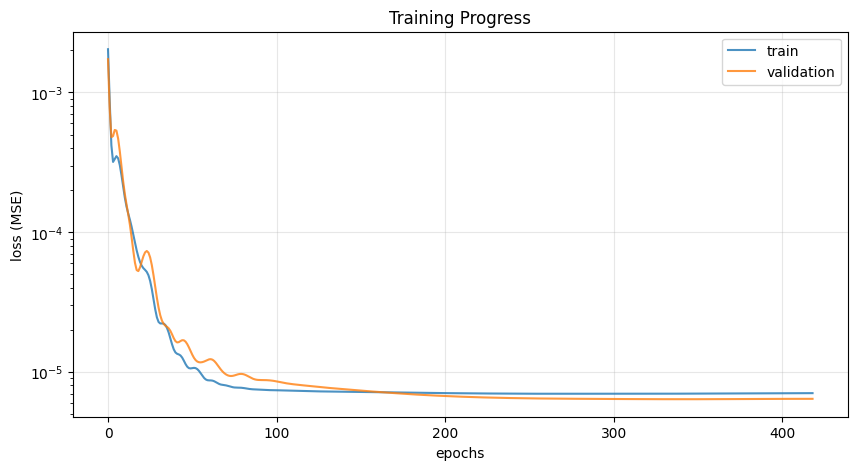

In [9]:
#optimizer = torch.optim.Adam(dynamics.parameters(), lr=0.01)
# ===== OPTIMIZER & SCHEDULER =====
optimizer = torch.optim.Adam(
    dynamics.parameters(), 
    lr=0.005,              # Reduced from 0.01 (↓50%)
    weight_decay=1e-5      # L2 regularization to prevent overfitting
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,            # Halve LR when plateau
    patience=50,           # Wait 50 epochs
    min_lr=1e-5,           # Don't go below this
)

# Split dataset into training and validation
# # train_ratio = 0.7
# train_data, validation_data = data[:int(train_ratio * len(data))], data[int(train_ratio * len(data)):]
# ===== DATA SPLIT =====
train_ratio = 0.8         # Increased from 0.7 (more training data)
train_data = data[:int(train_ratio * len(data))]      # 4000 samples
validation_data = data[int(train_ratio * len(data)):] # 1000 samples

def compute_loss(model, data_t, loss_func = torch.nn.MSELoss()):
    states, actions, next_states = data_t
    predictions = model(states, actions)
    return loss_func(predictions, next_states)

def transpose_batch(batch):
    return Transition(*map(torch.stack, zip(*batch)))

# ===== TRAINING SETTINGS =====
early_stopping_patience = 80
def train(model, train_data, validation_data, epochs=1500):
    train_data_t = transpose_batch(train_data)
    validation_data_t = transpose_batch(validation_data)
    losses = []

    # ===== New code =====
    best_val_loss = float('inf') 
    epochs_no_improve = 0
    best_model_state = None

    for epoch in trange(epochs, desc="Train dynamics"):
        # Forward pass
        loss = compute_loss(model, train_data_t)
        validation_loss = compute_loss(model, validation_data_t)
        
        # Store losses
        losses.append([loss.item(), validation_loss.item()])
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Update learning rate based on validation loss
        scheduler.step(validation_loss)
        
        # Early stopping check
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= early_stopping_patience:
            print(f"\nEarly stopping at epoch {epoch}")
            print(f"Best validation loss: {best_val_loss:.6f}")
            model.load_state_dict(best_model_state)
            break
        
        # Print progress every 100 epochs
        if (epoch + 1) % 100 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"\nEpoch {epoch+1}: train={loss.item():.6f}, "
                  f"val={validation_loss.item():.6f}, lr={current_lr:.6f}")
    
    # Plot losses
    losses = np.array(losses)
    plt.figure(figsize=(10, 5))
    plt.plot(losses[:, 0], label='train', alpha=0.8)
    plt.plot(losses[:, 1], label='validation', alpha=0.8)
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss (MSE)")
    plt.title("Training Progress")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return losses

# Train the model
losses = train(dynamics, train_data, validation_data, epochs=600)
    # ===== End of new code =====

# ==== Legacy code =====
#     for epoch in trange(epochs, desc="Train dynamics"):
#         # Compute loss gradient and step optimizer
#         loss = compute_loss(model, train_data_t)
#         validation_loss = compute_loss(model, validation_data_t)
#         losses[epoch] = [loss.detach().numpy(), validation_loss.detach().numpy()]
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     # Plot losses
#     plt.plot(losses)
#     plt.yscale("log")
#     plt.xlabel("epochs")
#     plt.ylabel("loss")
#     plt.legend(["train", "validation"])
#     plt.show()

# train(dynamics, data, validation_data)
# ==== End of legacy code =====

## Visualize trained dynamics

In order to qualitatively evaluate our model, we can choose some values of steering angle *(right, center, left)* and acceleration *(slow, fast)* in order to predict and visualize the corresponding trajectories from an initial state.  


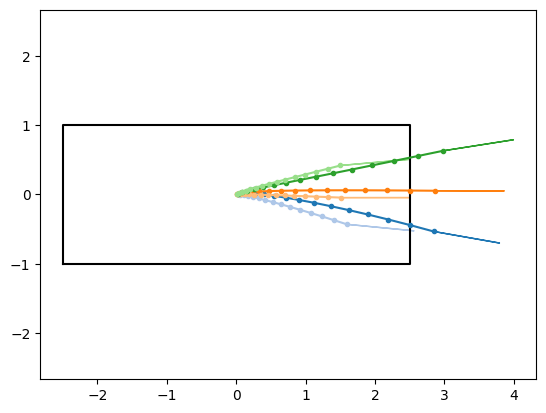

In [10]:
def predict_trajectory(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat):
            state = model(state, action)
            states.append(state)
    return torch.stack(states, dim=0)

def plot_trajectory(states, color):
    scales = np.array(env.unwrapped.config["observation"]["scales"])
    states = np.clip(states.squeeze(1).detach().numpy() * scales, -100, 100)
    plt.plot(states[:, 0], states[:, 1], color=color, marker='.')
    plt.arrow(states[-1,0], states[-1,1], states[-1,4]*1, states[-1,5]*1, color=color)

def visualize_trajectories(model, state, horizon=15):
    plt.cla()
    # Draw a car
    plt.plot(state.numpy()[0]+2.5*np.array([-1, -1, 1, 1, -1]),
             state.numpy()[1]+1.0*np.array([-1, 1, 1, -1, -1]), 'k')
    # Draw trajectories
    state = state.unsqueeze(0)
    colors = iter(plt.get_cmap("tab20").colors)
    # Generate commands
    for steering in np.linspace(-0.5, 0.5, 3):
        for acceleration in np.linspace(0.8, 0.4, 2):
            actions = torch.Tensor([acceleration, steering]).view(1,1,-1)
            # Predict trajectories
            states = predict_trajectory(state, actions, model, action_repeat=horizon)
            plot_trajectory(states, color=next(colors))
    plt.axis("equal")
    plt.show()
    
visualize_trajectories(dynamics, state=torch.Tensor([0, 0, 0, 0, 1, 0]))

## Reward model
We assume that the reward $R(s,a)$ is known (chosen by the system designer), and takes the form of a **weighted L1-norm** between the state and the goal.

In [11]:
def reward_model(states, goal, gamma=None, terminal_weight=1.0):
    """
        The reward is a weighted L1-norm between the state and a goal
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a goal state. shape: [state_size].
    :param float gamma: a discount factor
    """
    goal = goal.expand(states.shape)
    reward_weigths = torch.Tensor(env.unwrapped.config["reward_weights"])
    rewards = -torch.pow(torch.norm((states-goal)*reward_weigths, p=1, dim=-1), 0.5)
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)

    # NEW: Apply extra weight to terminal state (last timestep)
    if terminal_weight != 1.0:
        terminal_mask = torch.zeros_like(rewards)
        terminal_mask[-1] = terminal_weight - 1.0  # Extra weight on last timestep
        rewards = rewards * (1.0 + terminal_mask)
    
    return rewards

obs, info = env.reset()
print("Reward of a sample transition:", reward_model(torch.Tensor(obs["observation"]).unsqueeze(0),
                                                     torch.Tensor(obs["desired_goal"])))

Reward of a sample transition: tensor([-0.4043])


## Leverage dynamics model for planning

We now use the learnt dynamics model $f_\theta$ for planning.
In order to solve the optimal control problem, we use a sampling-based optimization algorithm: the **Cross-Entropy Method** (`CEM`). It is an optimization algorithm applicable to problems that are both **combinatorial** and **continuous**, which is our case: find the best performing sequence of actions.

This method approximates the optimal importance sampling estimator by repeating two phases:
1. **Draw samples** from a probability distribution. We use Gaussian distributions over sequences of actions.
2. Minimize the **cross-entropy** between this distribution and a **target distribution** to produce a better sample in the next iteration. We define this target distribution by selecting the top-k performing sampled sequences.

![Credits to Olivier Sigaud](https://github.com/yfletberliac/rlss2019-hands-on/blob/master/imgs/cem.png?raw=1)

Note that as we have a local linear dynamics model, we could instead choose an `Iterative LQR` planner which would be more efficient. We prefer `CEM` in this educational setting for its simplicity and generality.

In [12]:
def cem_planner(state, goal, action_size, horizon=12, population=200, selection=20, iterations=8):
    state = state.expand(population, -1)
    action_mean = torch.zeros(horizon, 1, action_size)
    action_std = torch.ones(horizon, 1, action_size)
    for _ in range(iterations):
        # 1. Draw sample sequences of actions from a normal distribution
        actions = torch.normal(mean=action_mean.repeat(1, population, 1), std=action_std.repeat(1, population, 1))
        actions = torch.clamp(actions, min=env.action_space.low.min(), max=env.action_space.high.max())
        states = predict_trajectory(state, actions, dynamics, action_repeat=1)
        # 2. Fit the distribution to the top-k performing sequences
        returns = reward_model(states, goal, gamma=None, terminal_weight = 2.5).sum(dim=0)
        _, best = returns.topk(selection, largest=True, sorted=False)
        best_actions = actions[:, best, :]
        action_mean = best_actions.mean(dim=1, keepdim=True)
        action_std = best_actions.std(dim=1, unbiased=False, keepdim=True)
    return action_mean[0].squeeze(dim=0)
  
print(torch.Tensor(obs['desired_goal'])) 
# Run the planner on a sample transition
action = cem_planner(torch.Tensor(obs["observation"]),
                     torch.Tensor(obs["desired_goal"]),
                     env.action_space.shape[0])
print("Planned action:", action)


tensor([-1.8000e-01, -1.4000e-01,  0.0000e+00,  0.0000e+00,  6.1232e-17,
        -1.0000e+00])
Planned action: tensor([ 0.9710, -0.4894])


## Visualize a few episodes

En voiture, Simone !

In [13]:
# env = gym.make("parking-reverse-dynObs-v0", render_mode='rgb_array', config=config)
env = gym.make("parking-reverse-dynObs-v0", render_mode='rgb_array')
duration = env.unwrapped.config["duration"]
env = record_videos(env)
obs, info = env.reset()

# Storage for trajectory data
trajectory_data = {
    'time': [],
    'x': [],
    'y': [],
    'vx': [],
    'vy': [],
    'heading': [],
    'cos_h': [],
    'sin_h': [],
    'goal_x': [],
    'goal_y': [],
    'episode': [],
    'reward': [],
    'action_accel': [],
    'action_steer': []
}

current_episode = 0
time_step = 0

for step in trange(3 * duration, desc="Testing 3 episodes..."):
    action = cem_planner(torch.Tensor(obs["observation"]),
                         torch.Tensor(obs["desired_goal"]),
                         env.action_space.shape[0])

    # Store current state
    trajectory_data['time'].append(time_step)
    trajectory_data['x'].append(obs["observation"][0])
    trajectory_data['y'].append(obs["observation"][1])
    trajectory_data['vx'].append(obs["observation"][2])
    trajectory_data['vy'].append(obs["observation"][3])
    trajectory_data['cos_h'].append(obs["observation"][4])
    trajectory_data['sin_h'].append(obs["observation"][5])

    # Compute heading angle from cos_h and sin_h
    heading_rad = np.arctan2(obs["observation"][5], obs["observation"][4])
    trajectory_data['heading'].append(np.rad2deg(heading_rad))
    
    # Store goal
    trajectory_data['goal_x'].append(obs["desired_goal"][0])
    trajectory_data['goal_y'].append(obs["desired_goal"][1])
    
    # Store action
    trajectory_data['action_accel'].append(action.numpy()[0])
    trajectory_data['action_steer'].append(action.numpy()[1])
    
    trajectory_data['episode'].append(current_episode)

    obs, reward, done, truncated, info = env.step(action.numpy())
    trajectory_data['reward'].append(reward)

    time_step += 1

    if done or truncated:
        obs, info = env.reset()
        current_episode += 1
        time_step = 0
env.close()
show_videos()

# ===== Convert to numpy arrays for plotting =====
for key in trajectory_data:
    trajectory_data[key] = np.array(trajectory_data[key])

print(f"\nTotal timesteps recorded: {len(trajectory_data['time'])}")
print(f"Episodes completed: {current_episode + 1}")

/opt/anaconda3/envs/parking/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/mehaksingal/Documents/CS269-Parking-2/scripts/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Testing 3 episodes...: 100%|██████████| 300/300 [00:10<00:00, 29.62it/s]



Total timesteps recorded: 300
Episodes completed: 3


## Visualization Code

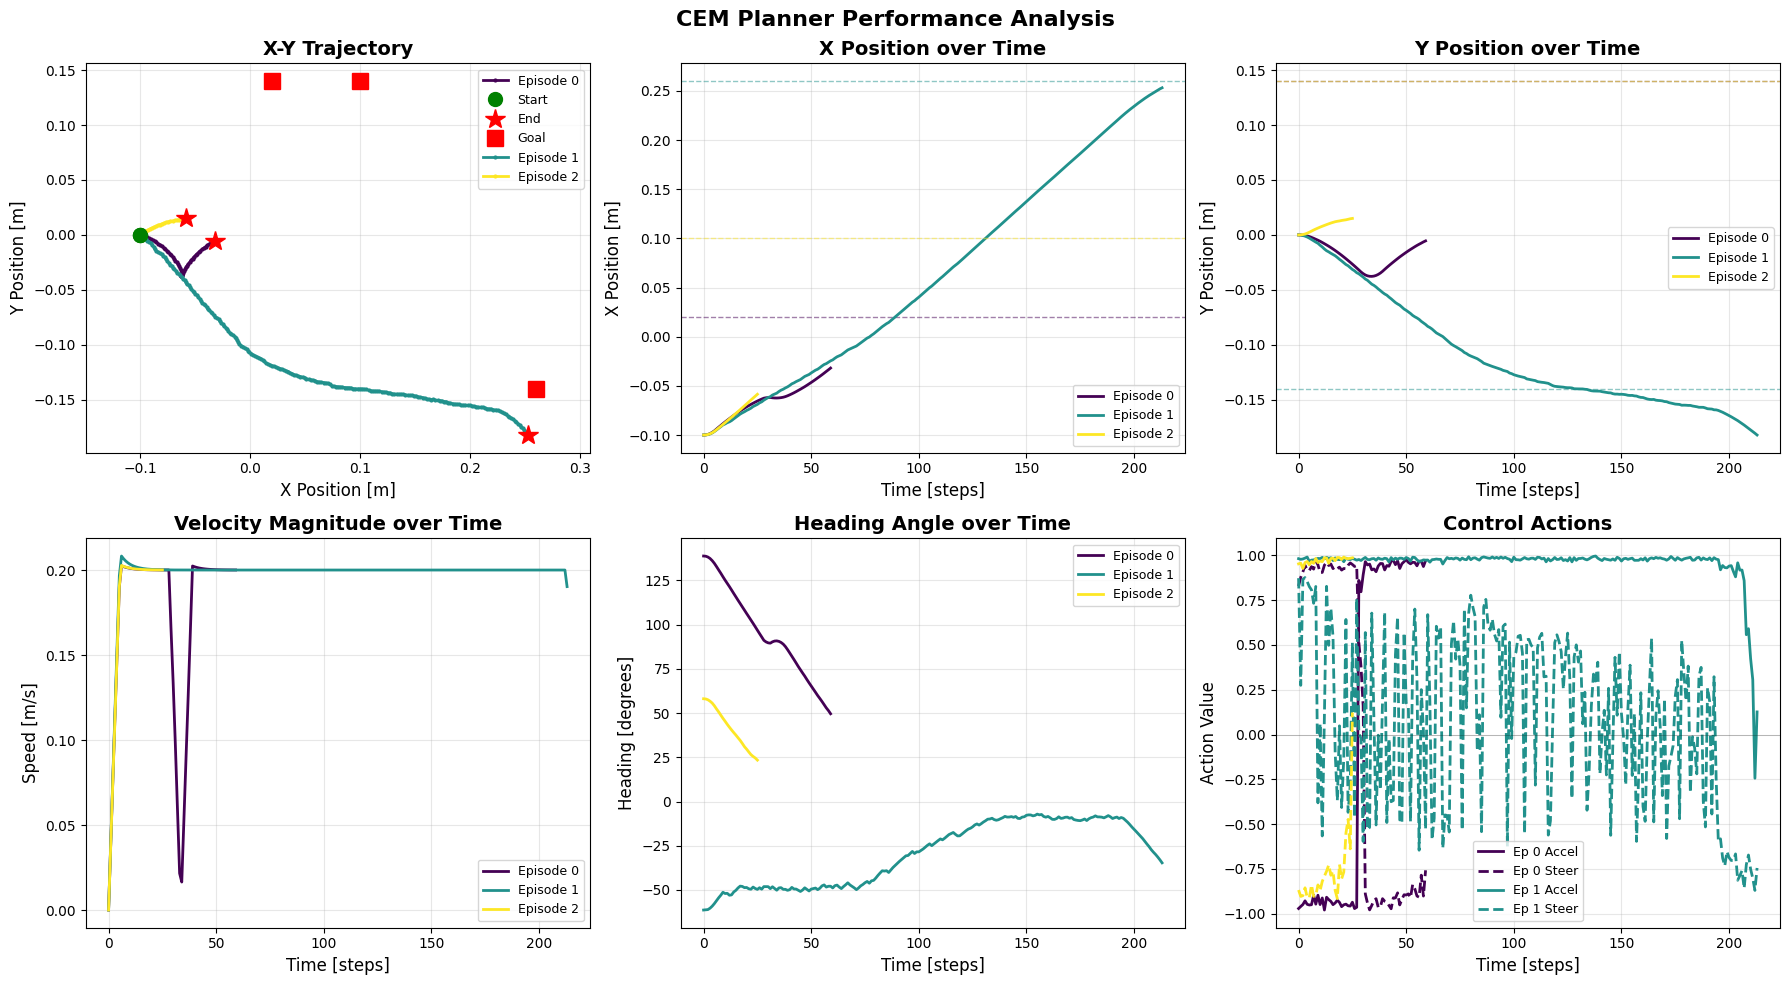

In [14]:
# ===== PLOT 1: Position Trajectories (X-Y Plot) =====
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('CEM Planner Performance Analysis', fontsize=16, fontweight='bold')

# Get episode boundaries for coloring
episodes = trajectory_data['episode']
unique_episodes = np.unique(episodes)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_episodes)))

# Plot 1: X-Y Trajectory
ax = axes[0, 0]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    ax.plot(trajectory_data['x'][mask], 
            trajectory_data['y'][mask], 
            color=colors[i], 
            label=f'Episode {int(ep)}',
            linewidth=2,
            marker='o',
            markersize=2)
    
    # Mark start and end
    ax.plot(trajectory_data['x'][mask][0], 
            trajectory_data['y'][mask][0], 
            'go', markersize=10, label='Start' if i == 0 else '')
    ax.plot(trajectory_data['x'][mask][-1], 
            trajectory_data['y'][mask][-1], 
            'r*', markersize=15, label='End' if i == 0 else '')
    
    # Mark goal
    ax.plot(trajectory_data['goal_x'][mask][0], 
            trajectory_data['goal_y'][mask][0], 
            'rs', markersize=12, label='Goal' if i == 0 else '')

ax.set_xlabel('X Position [m]', fontsize=12)
ax.set_ylabel('Y Position [m]', fontsize=12)
ax.set_title('X-Y Trajectory', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
ax.axis('equal')

# Plot 2: X Position vs Time
ax = axes[0, 1]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['x'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)
    ax.axhline(y=trajectory_data['goal_x'][mask][0], 
               color=colors[i], linestyle='--', alpha=0.5, linewidth=1)

ax.set_xlabel('Time [steps]', fontsize=12)
ax.set_ylabel('X Position [m]', fontsize=12)
ax.set_title('X Position over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# Plot 3: Y Position vs Time
ax = axes[0, 2]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['y'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)
    ax.axhline(y=trajectory_data['goal_y'][mask][0], 
               color=colors[i], linestyle='--', alpha=0.5, linewidth=1)

ax.set_xlabel('Time [steps]', fontsize=12)
ax.set_ylabel('Y Position [m]', fontsize=12)
ax.set_title('Y Position over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# Plot 4: Velocity Magnitude
ax = axes[1, 0]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    velocity = np.sqrt(trajectory_data['vx'][mask]**2 + trajectory_data['vy'][mask]**2)
    ax.plot(time_ep, velocity, 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)

ax.set_xlabel('Time [steps]', fontsize=12)
ax.set_ylabel('Speed [m/s]', fontsize=12)
ax.set_title('Velocity Magnitude over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# Plot 5: Heading Angle
ax = axes[1, 1]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['heading'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)

ax.set_xlabel('Time [steps]', fontsize=12)
ax.set_ylabel('Heading [degrees]', fontsize=12)
ax.set_title('Heading Angle over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# Plot 6: Actions
ax = axes[1, 2]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['action_accel'][mask], 
            color=colors[i], linestyle='-', linewidth=2, 
            label=f'Ep {int(ep)} Accel' if i < 2 else '')
    ax.plot(time_ep, trajectory_data['action_steer'][mask], 
            color=colors[i], linestyle='--', linewidth=2, 
            label=f'Ep {int(ep)} Steer' if i < 2 else '')

ax.set_xlabel('Time [steps]', fontsize=12)
ax.set_ylabel('Action Value', fontsize=12)
ax.set_title('Control Actions', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()

## Additional Detailed Plots

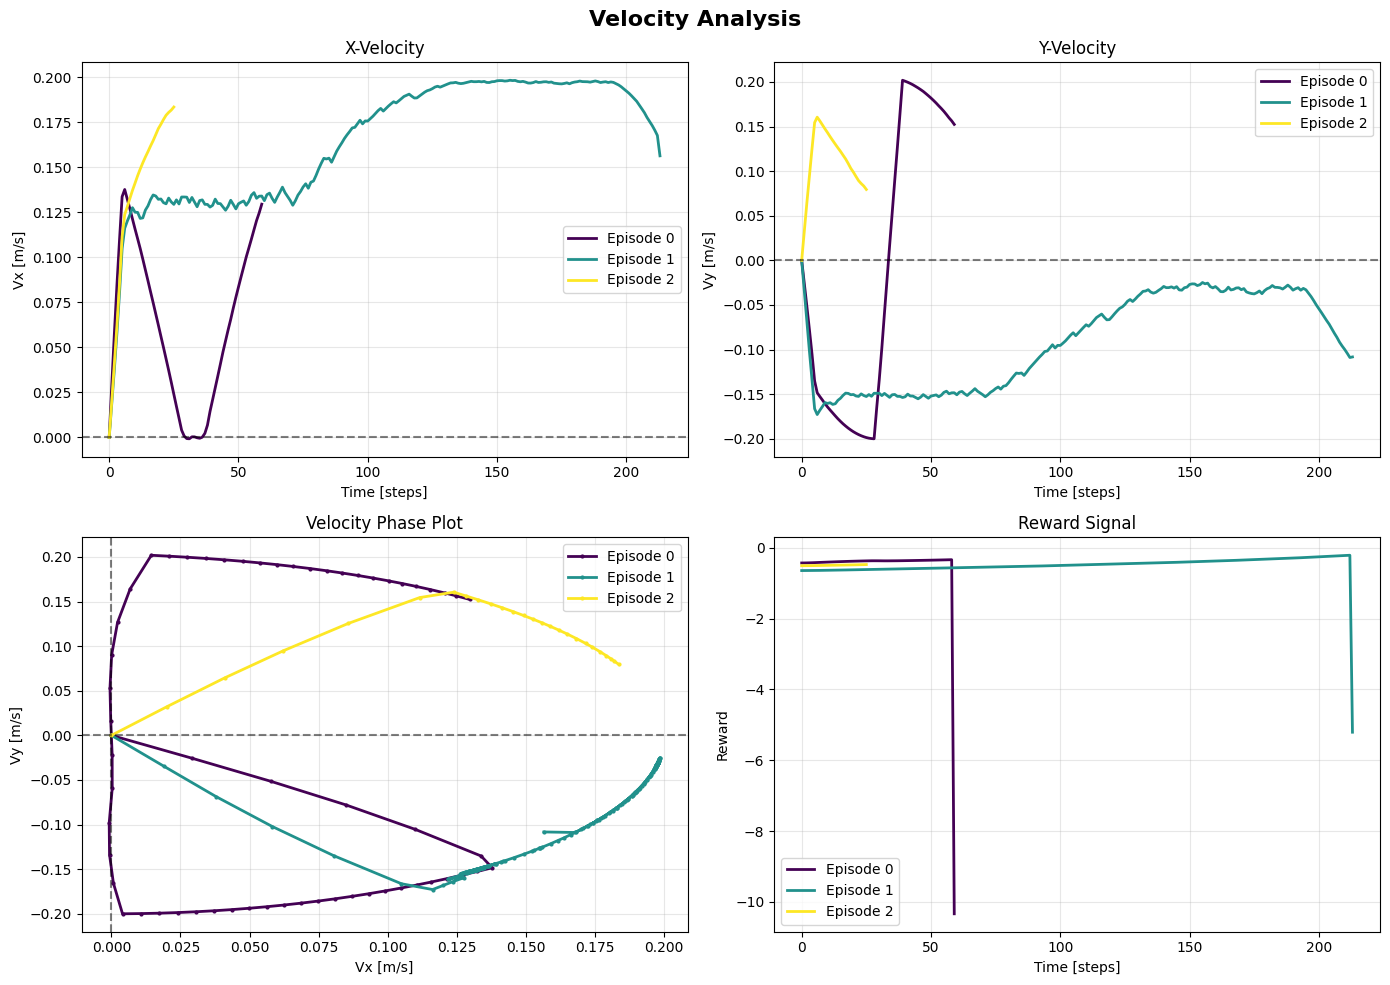

In [15]:
# ===== PLOT 2: Velocity Components =====
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Velocity Analysis', fontsize=16, fontweight='bold')

# Vx over time
ax = axes[0, 0]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['vx'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)
ax.set_xlabel('Time [steps]')
ax.set_ylabel('Vx [m/s]')
ax.set_title('X-Velocity')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Vy over time
ax = axes[0, 1]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['vy'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)
ax.set_xlabel('Time [steps]')
ax.set_ylabel('Vy [m/s]')
ax.set_title('Y-Velocity')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Velocity phase plot (vx vs vy)
ax = axes[1, 0]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    ax.plot(trajectory_data['vx'][mask], 
            trajectory_data['vy'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', 
            linewidth=2, marker='o', markersize=2)
ax.set_xlabel('Vx [m/s]')
ax.set_ylabel('Vy [m/s]')
ax.set_title('Velocity Phase Plot')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)

# Reward over time
ax = axes[1, 1]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['reward'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)
ax.set_xlabel('Time [steps]')
ax.set_ylabel('Reward')
ax.set_title('Reward Signal')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## Performance Metrics Summary

In [16]:
# ===== COMPUTE METRICS PER EPISODE =====
print("\n" + "="*70)
print("PERFORMANCE METRICS PER EPISODE")
print("="*70)

for ep in unique_episodes:
    mask = episodes == ep
    
    # Final position error
    final_x = trajectory_data['x'][mask][-1]
    final_y = trajectory_data['y'][mask][-1]
    goal_x = trajectory_data['goal_x'][mask][0]
    goal_y = trajectory_data['goal_y'][mask][0]
    
    pos_error = np.sqrt((final_x - goal_x)**2 + (final_y - goal_y)**2)
    
    # Final heading error
    final_heading = trajectory_data['heading'][mask][-1]
    goal_heading = np.rad2deg(np.arctan2(
        trajectory_data['goal_y'][mask][0] - trajectory_data['y'][mask][0],
        trajectory_data['goal_x'][mask][0] - trajectory_data['x'][mask][0]
    ))
    heading_error = abs(final_heading - goal_heading)
    
    # Average reward
    avg_reward = np.mean(trajectory_data['reward'][mask])
    total_reward = np.sum(trajectory_data['reward'][mask])
    
    # Max velocity
    max_speed = np.max(np.sqrt(trajectory_data['vx'][mask]**2 + 
                                trajectory_data['vy'][mask]**2))
    
    # Episode duration
    episode_length = np.sum(mask)
    
    print(f"\nEpisode {int(ep)}:")
    #Print goal position
    print(f"  Goal Position:         {goal_x:.3f}, {goal_y:.3f}")
    print(f"  Final Position Error:  {pos_error:.3f} m")
    print(f"  Final Heading Error:   {heading_error:.1f}°")
    print(f"  Average Reward:        {avg_reward:.3f}")
    print(f"  Total Reward:          {total_reward:.2f}")
    print(f"  Max Speed:             {max_speed:.2f} m/s")
    print(f"  Episode Length:        {episode_length} steps")
    print(f"  Success: {'✅ YES' if pos_error < 0.5 else '❌ NO'}")

print("\n" + "="*70)


PERFORMANCE METRICS PER EPISODE

Episode 0:
  Goal Position:         0.020, 0.140
  Final Position Error:  0.154 m
  Final Heading Error:   0.2°
  Average Reward:        -0.542
  Total Reward:          -32.50
  Max Speed:             0.20 m/s
  Episode Length:        60 steps
  Success: ✅ YES

Episode 1:
  Goal Position:         0.260, -0.140
  Final Position Error:  0.043 m
  Final Heading Error:   13.4°
  Average Reward:        -0.492
  Total Reward:          -105.31
  Max Speed:             0.21 m/s
  Episode Length:        214 steps
  Success: ✅ YES

Episode 2:
  Goal Position:         0.100, 0.140
  Final Position Error:  0.202 m
  Final Heading Error:   11.6°
  Average Reward:        -0.492
  Total Reward:          -12.79
  Max Speed:             0.20 m/s
  Episode Length:        26 steps
  Success: ✅ YES



## Limitations

### Model bias

In model-based reinforcement learning, we replace our original optimal control problem by another problem: optimizing our learnt approximate MDP. When settling for this approximate MDP to plan with, we introduce a **bias** that can only **decrease the true performance** of the corresponding planned policy. This is called the problem of model bias.

In some MDPs, even slight model errors lead to a dramatic drop in performance, as illustrated in the beginning of the following video:

[![Approximate Robust Control of Uncertain Dynamical Systems](https://img.youtube.com/vi/8khqd3BJo0A/0.jpg)](https://www.youtube.com/watch?v=8khqd3BJo0A)

The question of how to address model bias belongs to the field of **Safe Reinforcement Learning**. 

### [The call of the void](https://www.urbandictionary.com/define.php?term=the%20call%20of%20the%20void)

The model will be accurate only on some region of the state space that was explored and covered in $D$.
Outside of $D$, the model may diverge and **hallucinate** important rewards.
This effect is problematic when the model is used by a planning algorithm, as the latter will try to **exploit** these hallucinated high rewards and will steer the agent towards **unknown** (and thus dangerous) **regions** where the model is erroneously optimistic.

### Computational cost of planning

At test time, the planning step typically requires **sampling a lot of trajectories** to find a near-optimal candidate, which may turn out to be very costly. This may be prohibitive in a high-frequency real-time setting. The **model-free** methods which directly recommend the best action are **much more efficient** in that regard.